In [3]:
!pip install bio-datasets

  Using cached bio_datasets-0.0.4-py3-none-any.whl.metadata (2.4 kB)
  Using cached google_cloud_storage-1.37.1-py2.py3-none-any.whl.metadata (4.7 kB)
  Using cached tqdm-4.60.0-py2.py3-none-any.whl.metadata (57 kB)
  Using cached google_auth-1.35.0-py2.py3-none-any.whl.metadata (3.5 kB)
  Using cached google_cloud_core-1.7.3-py2.py3-none-any.whl.metadata (2.4 kB)
  Using cached google_resumable_media-1.3.3-py2.py3-none-any.whl.metadata (2.2 kB)
  Using cached cachetools-4.2.4-py3-none-any.whl.metadata (4.8 kB)
INFO: pip is looking at multiple versions of google-api-core to determine which version is compatible with other requirements. This could take a while.
  Using cached google_api_core-2.17.0-py3-none-any.whl.metadata (2.7 kB)
  Using cached google_api_core-2.16.2-py3-none-any.whl.metadata (2.7 kB)
  Using cached google_api_core-2.16.1-py3-none-any.whl.metadata (2.7 kB)
  Using cached google_api_core-2.16.0-py3-none-any.whl.metadata (2.7 kB)
  Using cached google_api_core-2.15.0-p

In [23]:
import numpy as np
from biodatasets import list_datasets, load_dataset
from deepchain.models import MLP
from deepchain.models.utils import confusion_matrix_plot, model_evaluation_accuracy
from sklearn.model_selection import train_test_split
import os
old = os.listdir
opj = os.path.join


In [15]:
list_datasets()

['quaternary-structure',
 'pathogen',
 'RNABindingProtein',
 'solubility',
 'netmhcpan-4.1-train',
 'ontologyprediction',
 'alphafold',
 'ontologyprediction-test',
 'cif',
 'pfam-32.0',
 'swissProt',
 'antibiotic-resistance',
 'stability',
 'toxicity',
 'antibodybinding']

In [16]:
# Load embedding and target dataset
pathogen = load_dataset("pathogen")

INFO: Start downloading pathogen dataset in /home/mtx/.cache/bio-datasets/pathogen ...
dataset.csv: 35.7MB [00:03, 10.3MB/s]                            
INFO: File pathogen/dataset.csv downloaded from Google Bucket 'deepchain-datasets-public' at /home/mtx/.cache/bio-datasets/pathogen/dataset.csv
description.md: 8.00kB [00:00, 31.5kB/s]
INFO: File pathogen/description.md downloaded from Google Bucket 'deepchain-datasets-public' at /home/mtx/.cache/bio-datasets/pathogen/description.md
info.json: 8.00kB [00:00, 31.9kB/s]
INFO: File pathogen/info.json downloaded from Google Bucket 'deepchain-datasets-public' at /home/mtx/.cache/bio-datasets/pathogen/info.json
sequence_protbert_cls_embeddings.npy: 376MB [00:20, 19.6MB/s]                              
INFO: File pathogen/sequence_protbert_cls_embeddings.npy downloaded from Google Bucket 'deepchain-datasets-public' at /home/mtx/.cache/bio-datasets/pathogen/sequence_protbert_cls_embeddings.npy


In [17]:

_, y = pathogen.to_npy_arrays(input_names=["sequence"], target_names=["class"])
embeddings = pathogen.get_embeddings("sequence", "protbert", "cls")

x_train, x_test, y_train, y_test = train_test_split(embeddings, y[0], test_size=0.3)

# Build a multi-layer-perceptron on top of embedding

# The fit method can handle all the arguments available in the
# 'trainer' class of pytorch lightning :
#               https://pytorch-lightning.readthedocs.io/en/latest/common/trainer.html
# Example arguments:
# * specifies all GPUs regardless of its availability :
#               Trainer(gpus=-1, auto_select_gpus=False, max_epochs=20)


In [26]:
# Input variables for MLP
modeldir = '../models'
modelname = 'model.pt'
modelpath = os.path.join(modeldir, modelname)

n_class = len(np.unique(y_train))
input_shape = x_train.shape[1]

mlp = MLP(input_shape=input_shape, n_class=n_class)
mlp.fit(x_train, y_train, epochs=5)
mlp.save(modelpath)


2024-03-04 20:14:21,595:INFO: This is a binary classification problem
2024-03-04 20:14:21,609:INFO: This is a binary classification problem
GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name       | Type       | Params
------------------------------------------
0 | activation | Sigmoid    | 0     
1 | model      | Sequential | 131 K 
2 | loss       | BCELoss    | 0     
------------------------------------------
131 K     Trainable params
0         Non-trainable params
131 K     Total params
0.525     Total estimated model params size (MB)


Epoch 4: 100%|██████████| 2109/2109 [00:08<00:00, 235.02it/s, loss=0.0525, v_num=1]


2024-03-04 20:15:07,104:INFO: Save state_dict parameters in model.pt


In [27]:
# Model evaluation
y_pred = mlp(x_test).squeeze().detach().numpy()
model_evaluation_accuracy(y_test, y_pred)

 Test :  accuracy score : 0.95 - AUC score : 0.99  


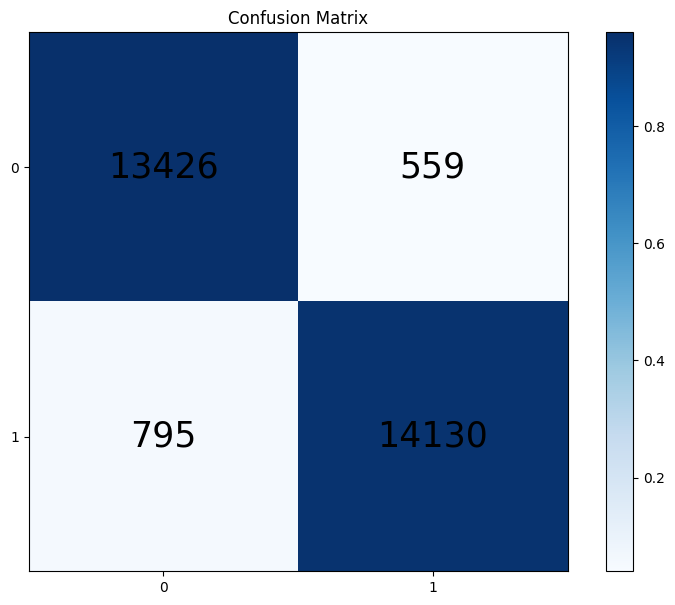

In [28]:
# Plot confusion matrix
confusion_matrix_plot(y_test, (y_pred > 0.5).astype(int), ["0", "1"])

In [34]:
tp=13426
fp=559
fn=795
tn=14130


In [35]:
acc=(tp+tn)/(tp+fp+fn+tn)
acc

0.9531649948114839